# **Dependancy**

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras.layers 

from google.colab import files
import io

import tensorboard
from datetime import datetime

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from tensorflow.python.keras.utils.vis_utils import plot_model

In [ ]:
pip install deepxde

# **Prepare Data**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Jumps to the desired directory
%cd 'drive/My Drive/Analytical Data'

/content/drive/My Drive/Analytical Data


In [5]:
p1 = genfromtxt('T_q100_v200_T25_D100.csv', delimiter=',')
times = genfromtxt('time.csv', delimiter=',')

In [6]:
times = times.reshape((100,1))
times.shape

(100, 1)

In [7]:
points = p1[:, 1:3]
points.shape

(1681, 2)

In [8]:
temps = p1[:, 5:]
temps.shape

(1681, 100)

In [9]:
temps[0]

array([ 133.85,  162.48,  199.26,  246.52,  307.16,  384.65,  483.07,
        606.97,  761.24,  950.74, 1179.9 , 1452.  , 1768.9 , 2129.8 ,
       2531.  , 2965.4 , 3422.4 , 3887.9 , 4345.3 , 4776.5 , 5163.1 ,
       5488.  , 5737.3 , 5900.9 , 5974.3 , 5957.9 , 5857.5 , 5683.4 ,
       5449.  , 5169.5 , 4860.6 , 4537.2 , 4212.4 , 3896.7 , 3598.1 ,
       3321.6 , 3070.  , 2844.2 , 2643.4 , 2465.9 , 2309.6 , 2171.8 ,
       2050.2 , 1942.4 , 1846.3 , 1760.2 , 1682.6 , 1612.2 , 1548.  ,
       1489.2 , 1435.  , 1384.9 , 1338.4 , 1295.1 , 1254.7 , 1216.9 ,
       1181.4 , 1148.  , 1116.6 , 1086.9 , 1058.8 , 1032.1 , 1006.9 ,
        982.88,  960.04,  938.28,  917.53,  897.71,  878.77,  860.64,
        843.27,  826.61,  810.63,  795.28,  780.53,  766.33,  752.66,
        739.49,  726.8 ,  714.55,  702.72,  691.29,  680.25,  669.57,
        659.23,  649.22,  639.53,  630.13,  621.02,  612.18,  603.6 ,
        595.27,  587.17,  579.3 ,  571.66,  564.22,  556.98,  549.93,
        543.07,  536

In [10]:
train_number = 1345 * 100
test_number = 110 * 100

Re-arranging

In [11]:
new_points = np.zeros((168100, 3))
for i in range(1681):
  for j in range(100):
    new_points[i * 100 + j] = [points[i][0], points[i][1], times[j]] # y, z, t 

In [ ]:
# In case to check every thing is correct
new_points[0:102]

In [12]:
new_temps = temps.reshape((168100,1))
new_temps[0:10]

array([[133.85],
       [162.48],
       [199.26],
       [246.52],
       [307.16],
       [384.65],
       [483.07],
       [606.97],
       [761.24],
       [950.74]])

### Now we have an input of size 168100 by 3 and output of size 168100 by 1

In [13]:
train_x = new_points[0:train_number]
train_y = new_temps[0:train_number]
test_x = new_points[train_number:]
test_y = new_temps[train_number:]

In [14]:
print(train_x.shape)
print(test_y.shape)

(134500, 3)
(33600, 1)


In [15]:
train_x[0]

array([1.       , 1.       , 0.0010971])

# **Model and PINN**

**This shows the equation**
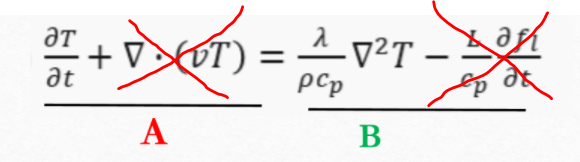

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term
Compiling model...
Building feed-forward neural network...
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
'build' took 0.095232 s

'compile' took 0.685524 s

Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric   
0         [1.67e-03]    [5.95e-04]    [9.99e-01]    
100       [1.92e-06]    [1.62e-06]    [1.00e+00]    

Best model at step 100:
  train loss: 1.92e-06
  test loss: 1.62e-06
  test metric: [1.00e+00]

'train' took 74.069927 s



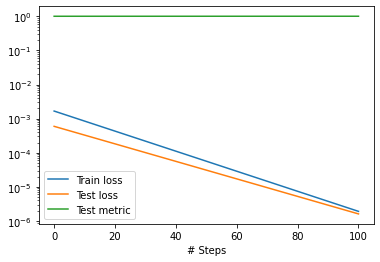

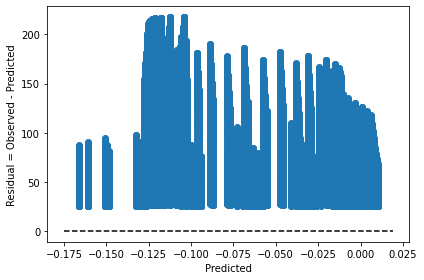

In [17]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

import deepxde as dde
from deepxde.backend import tf

# y(the input to the function) represents T(temperature) here.
# dT_t = dT_yy + dT_zz
def pde(x, y):
    D = tf.Variable(10e-5)
    dT_t = dde.grad.jacobian(y, x, j=2)
    dT_yy = dde.grad.hessian(y, x, j=1)
    dT_zz = dde.grad.hessian(y, x, j=0)
    return (dT_t - D * (dT_yy + dT_zz))



geom = dde.geometry.geometry_2d.Rectangle((0,0), (40,40))
timedomain = dde.geometry.TimeDomain(0, 0.003)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

data = dde.data.pde.TimePDE(geomtime,pde,[])
data.train_x = train_x
data.train_y = train_y
data.test_x = test_x
data.test_y = test_y

layer_size = [3] + [32] * 4 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=100)

dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [18]:
data.train_x.shape#x, t

(134500, 3)

In [19]:
data.train_y.shape# u

(134500, 1)

In [20]:
predictions = model.predict(train_x)

Predicting...
'predict' took 0.070050 s



In [21]:
predictions.shape

(134500, 1)

In [22]:
predictions[101:106]

array([[-0.16441411],
       [-0.16441411],
       [-0.16441375],
       [-0.16441375],
       [-0.1644139 ]], dtype=float32)

# **Plotting**

Tensor("Mean_2:0", shape=(), dtype=float32)


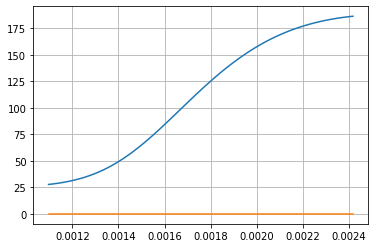

In [25]:
point_number = 100
predicted_temps = predictions[(point_number-1) * 100 : point_number * 100]
real_temps = test_y[(point_number-1) * 100 : point_number * 100]
fig, ax = plt.subplots()
ax.plot(times, real_temps)
ax.plot(times, predicted_temps)
plt.grid()
print(tf.keras.losses.MSE(temps[point_number], predictions[point_number]))